## Testing BoostingTreeModel Class with Energy Efficiency Dataset
This test evaluates the custom BoostingTreeModel class against the Scikit-learn GradientBoostingRegressor on the Energy Efficiency Dataset. The focus is on performance, accuracy, and residual analysis.
The target variable is the Heating Load (9th column of the dataset), and the input features include 8 building parameters such as wall area, roof area, glazing area, etc.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats
from time import time

In [10]:
class MyMSE:
    @staticmethod
    def calculate(y_true, y_pred):
        """
        Calculates the Mean Squared Error between true and predicted values.
        Args: y_true (np.array): Ground truth labels. | y_pred (np.array): Predicted labels.
        Returns: float: The mean squared error between y_true and y_pred.
        """
        return np.mean((y_true - y_pred) ** 2)

class MyRSquared:
    @staticmethod
    def calculate(y_true, y_pred):
        """
        Calculates the R-squared metric for regression.
        Args: y_true (np.array): Ground truth labels. | y_pred (np.array): Predicted labels.
        Returns: float: The R-squared value between y_true and y_pred.
        """
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 1 - (ss_res / ss_tot)

class BoostingTreeModel:
    def __init__(self, num_trees=20, learning_rate=0.1, max_depth=3, tol=1e-5, subsample=0.5):
        """
        Initializes a BoostingTreeModel object.
        Args:
            num_trees (int, optional): Number of trees to use in the ensemble. Defaults to 20.
            learning_rate (float, optional): Learning rate for the boosting process. Defaults to 0.1.
            max_depth (int, optional): Maximum depth of individual trees. Defaults to 3.
            tol (float, optional): Tolerance for early stopping. Defaults to 1e-5.
            subsample (float, optional): Fraction of data to use for training each tree (bagging). Defaults to 0.5.
        """
        self.num_trees = num_trees
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.tol = tol
        self.subsample = subsample
        self.trees = []
        self.base_pred = None
        self.error_progression = []

    def fit(self, X, y):
        """
        Fits the Gradient Boosting Tree model to the data.
        Args: X (np.array): Feature matrix. |  y (np.array): Target labels.
        Returns: BoostingTreeResults: Object containing the fitted model information.
        """
        X = np.nan_to_num(X, nan=0.0)
        y = np.nan_to_num(y, nan=0.0)
        # Ensure X is at least 2D
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        # Normalize data
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)
        X = (X - X_mean) / (X_std + 1e-8)
        self.base_pred = np.mean(y)
        y_pred = np.full(y.shape, self.base_pred)
        n_samples = X.shape[0]

        for i in range(self.num_trees):
            # Compute residuals
            residuals = y - y_pred

            # Subsample the data (if subsample < 1.0)
            if self.subsample < 1.0:
                idx = np.random.choice(n_samples, int(n_samples * self.subsample), replace=False)
                X_sub, residuals_sub = X[idx], residuals[idx]
            else:
                X_sub, residuals_sub = X, residuals

            # Fit a new tree on residuals
            tree = DecisionTreeRegressorCustom(max_depth=self.max_depth)
            tree.fit(X_sub, residuals_sub)
            tree_pred = tree.predict(X)

            # Update predictions with scaled tree predictions
            y_pred += self.learning_rate * tree_pred
            self.trees.append(tree)

            # Calculate Mean Squared Error
            mse = MyMSE.calculate(y, y_pred)
            self.error_progression.append(mse)

            # Stop training if the tolerance is reached
            if mse < self.tol:
                print(f"Converged after {i + 1} trees")
                break

        return BoostingTreeResults(self.base_pred, self.trees, self.learning_rate)

    def predict(self, X):
        """
        Predicts the target values for a given input matrix X.
        Args:X (np.array): Input feature matrix.
        Returns: np.array: Predicted target values.
    """
        X = np.nan_to_num(X, nan=0.0) # Replace NaN values in X with 0.0
        if X.ndim == 1: # If X is a 1-dimensional array, reshape it to a 2D array with one column
            X = X.reshape(-1, 1)
        # Calculate the mean and standard deviation of X along the columns
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)
        # Standardize X by subtracting the mean and dividing by the standard deviation
        # Adding a small constant (1e-8) to the denominator to prevent division by zero
        X = (X - X_mean) / (X_std + 1e-8)
        # Initialize the predictions array with the base prediction value for each sample
        y_pred = np.full(X.shape[0], self.base_pred)
        # Iterate through each tree in the ensemble
        for tree in self.trees:
            # Update the predictions by adding the scaled predictions from each tree
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred


class BoostingTreeResults:
    """
        Initializes a BoostingTreeResults object.
        Args:base_pred (float): The base prediction value.
            trees (list): A list of DecisionTreeRegressorCustom objects.
            learning_rate (float): The learning rate for updating predictions.
        """
    def __init__(self, base_pred, trees, learning_rate):
        self.base_pred = base_pred # Store the base prediction value
        self.trees = trees # Store the list of trees in the ensemble
        self.learning_rate = learning_rate # Store the learning rate for updates


    def predict(self, X):
        """
        Method to make predictions based on input features X
        Args: X (np.array): Input feature matrix.
            Returns: np.array: Predicted target values.
        """
        X = np.nan_to_num(X, nan=0.0) # Replace NaN values in X with 0.0
        if X.ndim == 1: # If X is a 1-dimensional array, reshape it to a 2D array with one column
            X = X.reshape(-1, 1)

        # Calculate the mean and standard deviation of X along the columns
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)

        # Standardize X by subtracting the mean and dividing by the standard deviation
        # Adding a small constant (1e-8) to the denominator to prevent division by zero
        X = (X - X_mean) / (X_std + 1e-8)

        # Initialize the predictions array with the base prediction value for each sample
        y_pred = np.full(X.shape[0], self.base_pred)

        # Iterate through each tree in the ensemble
        for tree in self.trees:
            # Update the predictions by adding the scaled predictions from each tree
            y_pred += self.learning_rate * tree.predict(X)

        return y_pred # Return the final predictions


class DecisionTreeRegressorCustom:
    """
    A decision tree regressor implementation.
    Attributes: max_depth (int): The maximum depth of the tree.
        min_samples_split (int): The minimum number of samples required to split   a node.
        tree (dict): The tree structure, represented as a nested dictionary.
    """
    # Initialize the DecisionTreeRegressorCustom with maximum depth and minimum samples required to split
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth  # Maximum depth of the tree
        self.min_samples_split = min_samples_split  # Minimum samples required to perform a split
        self.tree = None  # Placeholder for the tree structure

    # Fit the model to the training data (X, y)
    def fit(self, X, y):
        # Build the decision tree using the training data
        self.tree = self._build_tree(X, y, depth=0)

    # Predict the target values for the input data X
    def predict(self, X):
        # Traverse the tree for each sample in X and return the predictions as a numpy array
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    # Traverse the decision tree to find the prediction for a single sample x
    def _traverse_tree(self, x, node):
        # If the current node is a leaf node, return its value
        if "value" in node:
            return node["value"]

        # Get the feature value for the current node's feature index
        feature_value = x[node["feature_index"]]

        # Decide whether to traverse left or right based on the threshold
        if feature_value <= node["threshold"]:
            return self._traverse_tree(x, node["left"])  # Traverse left branch
        else:
            return self._traverse_tree(x, node["right"])  # Traverse right branch

    # Build the decision tree recursively
    def _build_tree(self, X, y, depth):
        # Check stopping criteria: max depth, minimum samples, or no variance in y
        if depth >= self.max_depth or len(y) < self.min_samples_split or np.var(y) == 0:
            return {"value": np.mean(y)}  # Return leaf node with mean value

        # Find the best feature and threshold to split on
        feature_index, threshold = self._find_best_split(X, y)
        if feature_index is None:
            return {"value": np.mean(y)}  # Return leaf node if no valid split found

        # Create boolean arrays for left and right splits based on the threshold
        left_indices = X[:, feature_index] <= threshold
        right_indices = X[:, feature_index] > threshold

        # Recursively build the left and right branches of the tree
        left_branch = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_branch = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        # Return the current node with feature index, threshold, and branches
        return {
            "feature_index": feature_index,
            "threshold": threshold,
            "left": left_branch,
            "right": right_branch,
        }

    # 
    def _find_best_split(self, X, y):
        """
        Find the best feature and threshold to split the data based on mean squared error reduction
        Args: X (np.array): The training features. |   y (np.array): The training targets.
        Returns: tuple: The best feature index and threshold.
        """
        best_split = None  # Initialize the best split
        best_mse_reduction = 0  # Initialize the best mean squared error reduction
        current_mse = np.var(y) * len(y)  # Calculate the current mean squared error

        # Iterate over each feature to find the best split
        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])  # Unique values of the feature
            for threshold in thresholds:
                # Create boolean arrays for left and right splits
                left_indices = X[:, feature_index] <= threshold
                right_indices = X[:, feature_index] > threshold

                # Skip if any split results in an empty set
                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                # Calculate mean squared error for left and right splits
                mse_left = np.var(y[left_indices]) * len(left_indices)
                mse_right = np.var(y[right_indices]) * len(right_indices)
                mse_split = mse_left + mse_right  # Total mean squared error after the split

                # Calculate the reduction in mean squared error
                mse_reduction = current_mse - mse_split
                # Update the best split if this one is better
                if mse_reduction > best_mse_reduction:
                    best_mse_reduction = mse_reduction
                    best_split = (feature_index, threshold)

        # Return the best split found, or (None, None) if no valid split exists
        return best_split if best_split else (None, None)

Test - Energy Efficiency Dataset (Heating Load)
Custom Boosting Tree - R²: 0.7194, MSE: 29.2460, Time: 0.0358s
Scikit-learn Boosting Tree - R²: 0.9511, MSE: 5.1016, Time: 0.0064s


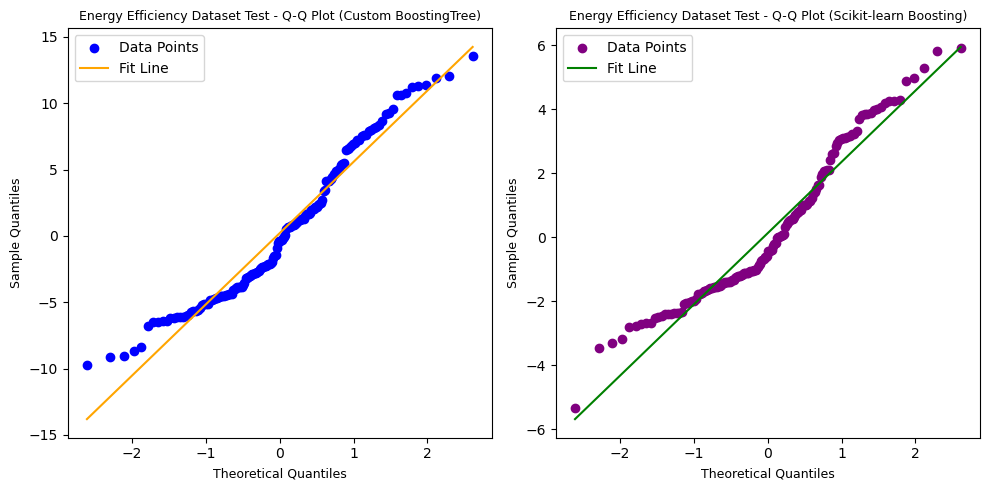

In [11]:
# Q-Q Plot function for residuals
def plot_qq(y_true, y_pred_custom, y_pred_sklearn, test_name):
    plt.figure(figsize=(10, 5))

    # Residuals for both models
    residuals_custom = y_true - y_pred_custom
    residuals_sklearn = y_true - y_pred_sklearn

    # Q-Q plot for custom Boosting Tree model residuals
    plt.subplot(1, 2, 1)
    (osm, osr), (slope, intercept, r) = stats.probplot(residuals_custom, dist="norm")
    plt.scatter(osm, osr, color="blue", label="Data Points")
    plt.plot(osm, slope * osm + intercept, color="orange", label="Fit Line")
    plt.title(f'{test_name} - Q-Q Plot (Custom BoostingTree)')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.legend()

    # Q-Q plot for Scikit-learn Boosting Tree model residuals
    plt.subplot(1, 2, 2)
    (osm, osr), (slope, intercept, r) = stats.probplot(residuals_sklearn, dist="norm")
    plt.scatter(osm, osr, color="purple", label="Data Points")
    plt.plot(osm, slope * osm + intercept, color="green", label="Fit Line")
    plt.title(f'{test_name} - Q-Q Plot (Scikit-learn Boosting)')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Load Energy Efficiency Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
data = pd.read_excel(url)

# Dataset Features and Targets
# X: Features (First 8 columns)
# y: Target (Heating Load - 9th column)
X = data.iloc[:, :8].values  # First 8 columns
y = data.iloc[:, 8].values   # 9th column (Heating Load)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameters for the model
num_trees = 20
learning_rate = 0.1
max_depth = 3
subsample = 0.5

# Custom Boosting Tree Model
custom_model = BoostingTreeModel(num_trees=num_trees, learning_rate=learning_rate, max_depth=max_depth, subsample=subsample)
start_time = time()
custom_results = custom_model.fit(X_train, y_train)
y_pred_custom = custom_results.predict(X_test)
custom_time = time() - start_time

# Scikit-learn Gradient Boosting Tree Model
sklearn_model = GradientBoostingRegressor(n_estimators=num_trees, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
start_time = time()
sklearn_model.fit(X_train, y_train)
y_pred_sklearn = sklearn_model.predict(X_test)
sklearn_time = time() - start_time

# Evaluation Metrics
r_squared_custom = r2_score(y_test, y_pred_custom)
mse_custom = mean_squared_error(y_test, y_pred_custom)
r_squared_sklearn = r2_score(y_test, y_pred_sklearn)
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)

# Print comparison results
print("Test - Energy Efficiency Dataset (Heating Load)")
print(f"Custom Boosting Tree - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}, Time: {custom_time:.4f}s")
print(f"Scikit-learn Boosting Tree - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}, Time: {sklearn_time:.4f}s")

# Q-Q Plot function for residuals
def plot_qq(y_true, y_pred_custom, y_pred_sklearn, test_name):
    plt.figure(figsize=(10, 5))

    # Residuals for both models
    residuals_custom = y_true - y_pred_custom
    residuals_sklearn = y_true - y_pred_sklearn

    # Q-Q plot for custom Boosting Tree model residuals
    plt.subplot(1, 2, 1)
    (osm, osr), (slope, intercept, r) = stats.probplot(residuals_custom, dist="norm")
    plt.scatter(osm, osr, color="blue", label="Data Points")
    plt.plot(osm, slope * osm + intercept, color="orange", label="Fit Line")
    plt.title(f'{test_name} - Q-Q Plot (Custom BoostingTree)',fontsize=9 )
    plt.xlabel('Theoretical Quantiles',fontsize=9)
    plt.ylabel('Sample Quantiles',fontsize=9)
    plt.legend()

    # Q-Q plot for Scikit-learn Boosting Tree model residuals
    plt.subplot(1, 2, 2)
    (osm, osr), (slope, intercept, r) = stats.probplot(residuals_sklearn, dist="norm")
    plt.scatter(osm, osr, color="purple", label="Data Points")
    plt.plot(osm, slope * osm + intercept, color="green", label="Fit Line")
    plt.title(f'{test_name} - Q-Q Plot (Scikit-learn Boosting)',fontsize=9 )
    plt.xlabel('Theoretical Quantiles',fontsize=9)
    plt.ylabel('Sample Quantiles',fontsize=9)
    plt.legend()

    plt.tight_layout()
    plt.show()


# Plot Q-Q plots for residual analysis
plot_qq(y_test, y_pred_custom, y_pred_sklearn, "Energy Efficiency Dataset Test")

The scikit-learn model significantly outperforms the custom implementation in both accuracy (higher  R^2 , lower MSE) and efficiency (faster training time) due to its highly optimized algorithms.

The custom model, while reasonably effective for a self-implemented algorithm, struggles to match scikit-learn’s performance, particularly in handling extreme values or outliers, as shown by residual deviations in Q-Q plots. This indicates potential underfitting or misrepresentation of patterns in the data.

The Q-Q plots confirm the scikit-learn model’s superior residual distribution and robustness compared to the custom implementation.
